# Example 2

## Boundary value problem

The objective in this example is to solve the 2D Laplace's equation that governs the potential flow around the cross section of a circular cilinder of radius $R$ placed in a uniform flow:

$$ \nabla^2 \Phi = 0 \quad \text{for} \quad r = \sqrt{x^2 + y^2} \ge R, \tag{1} $$

where $\Phi$ is the composition of the potential due to a uniform flow and the unkown distubance potential $\phi$.

$$ \Phi = Ux + \phi. \tag{2} $$

The no-penetration boundary condition states that:

$$ \frac{\partial \Phi}{\partial n} = 0 \quad \text{for} \quad \sqrt{x^2 + y^2} = R, \tag{3} $$

where $n$ is the unit vector normal to the surface of the body, which in `twodubem`'s reference points outward from the domain. In the case of a circular cylinder, this vector is coincident with the radial direction, but with opposite sign, and since $x$ can be written in polar coordinates as

$$ x = r \cos\theta, $$

$\dfrac{\partial \Phi}{\partial n}$ can be written as:

$$ \frac{\partial \Phi}{\partial n} = -U \cos\theta + \frac{\partial \phi}{\partial n}. \tag{4} $$

Therefore, starting from expression $(3)$ the boundary condition for the unkown potential $\phi$ is:

$$ \frac{\partial \phi}{\partial n} = U \frac{x}{R} \quad \text{for} \, (x, y) \, \text{on the boundary}. \tag{5} $$

## Analytical solution

The analytical solution for the total potential $\Phi$ is equivalent to the composition of the uniform flow and a dipole potentials. The dipole intensity can be calculated as a function of the uniform flow speed and the cylinder radius, giving the following expressions for the total potential and its gradient:

$$ \Phi = U x \left( 1 + \frac{R^2}{x^2 + y^2} \right), \tag{6} $$
$$ \Phi_x = U \left( 1 + \frac{R^2}{x^2 + y^2} - \frac{2 R^2 x^2}{(x^2 + y^2)^2} \right), \tag{7} $$
$$ \Phi_y = \frac{-2 U R^2 x y}{(x^2 + y^2)^2}. \tag{8} $$

The tangential velocity at the boundary of the cylinder as a function of the angle $\theta$, defined as the angle between the radius of a point on the boundary and the positive $x$ axis, is given by:

$$ V = 2 U \sin\theta. \tag{9} $$

From Bernoulli's theorem $(10)$ and the tangential velocity in $(9)$, we can derive the pressure coefficient $C_p$:

$$ p_0 - \frac{1}{2} \rho U^2 = p - \frac{1}{2} \rho V^2, \tag{10} $$

$$ C_p = \frac{p - p_0}{\frac{1}{2} \rho U^2} = 1 - 4 \sin^2\theta. \tag{11} $$

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Polygon as PolygonPatch
from twodubem import Boundary, Laplace, Solver

In [2]:
R = 1.0  # Cylinder radius.
U0 = 1.0  # Uniform flow speed.

# Points defining the circular boundary.
tv = np.linspace(0.0, 2*np.pi, 72)
xc = R * np.cos(tv)
yc = R * np.sin(tv)
vc = np.vstack((xc, yc)).T

# Grid points where results will be evaluated.
xv = np.linspace(-2.0, 2.0, 100)
yv = np.linspace(-2.0, 2.0, 100)
X, Y = np.meshgrid(xv, yv)

# Mask for points outside the domain (inside the circular boundary).
out_domain_mask = (X**2 + Y**2) < R**2

# Mask for points inside the domain (outside the circular boundary).
in_domain_mask = ~out_domain_mask

In [3]:
# Analytical solution in ℝ².
Phi_analytical = lambda x, y: U0 * x * (1.0 + R**2 / (x**2 + y**2))
Phix_analytical = lambda x, y: U0 * (1.0 + R**2 / (x**2 + y**2) - 2.0 * R**2 * x**2 / (x**2 + y**2)**2)
Phiy_analytical = lambda x, y: -2.0 * U0 * R**2 * x * y / (x**2 + y**2)**2
Phit_analytical = lambda x, y: U0 * y * (R**2 + x**2 + y**2) / np.sqrt((x**2 + y**2)**3)

Pa = Phi_analytical(X, Y)
Ua = Phix_analytical(X, Y)
Va = Phiy_analytical(X, Y)

# Analytical minimum and maximum in ℝ² \ {(x, y) | x² + y² < R²}.
Pa_min = Pa[in_domain_mask].min()
Pa_max = Pa[in_domain_mask].max()
Pa_med = 0.5 * (Pa_min + Pa_max)
Ua_min = Ua[in_domain_mask].min()
Ua_max = Ua[in_domain_mask].max()
Ua_med = 0.5 * (Ua_min + Ua_max)
Va_min = Va[in_domain_mask].min()
Va_max = Va[in_domain_mask].max()
Va_med = 0.5 * (Va_min + Va_max)

In [4]:
# Numerical solution with the Boundary Element Method, using constant elements.
def boundary_condition(point):
    x, y = point
    bc_type = 1
    bc_value = U0 * x / np.sqrt(x**2 + y**2)

    return bc_type, bc_value

# Number of circunferencial elements.
number_of_elements = 18

# The negative sign indicates that the domain lies outside the circular region.
C = -Boundary.circle([0.0, 0.0], R, number_of_elements, boundary_condition)

bem_solver = Solver(C, Laplace(), method='constant')
bem_solver.solve()

In [5]:
# BEM solution for the disturbance potential.
Phi_disturbance, gradPhi_disturbance = bem_solver.get_solution(X, Y)
Phix_disturbance = gradPhi_disturbance[:, :, 0]
Phiy_disturbance = gradPhi_disturbance[:, :, 1]

# Uniform flow.
Phi_uniform_flow = lambda x, y: U0 * x
Phix_uniform_flow = lambda x, y: U0
Phiy_uniform_flow = lambda x, y: 0.0
Phit_uniform_flow = lambda x, y: U0 * y / np.sqrt(x**2 + y**2)

# Total solution
Pb = Phi_uniform_flow(X, Y) + Phi_disturbance
Ub = Phix_uniform_flow(X, Y) + Phix_disturbance
Vb = Phiy_uniform_flow(X, Y) + Phiy_disturbance

# Numerical minimum and maximum on the domain's interior.
Pb_min = Pb[in_domain_mask].min()
Pb_max = Pb[in_domain_mask].max()
Pb_med = 0.5 * (Pb_min + Pb_max)
Ub_min = Ub[in_domain_mask].min()
Ub_max = Ub[in_domain_mask].max()
Ub_med = 0.5 * (Ub_min + Ub_max)
Vb_min = Vb[in_domain_mask].min()
Vb_max = Vb[in_domain_mask].max()
Vb_med = 0.5 * (Vb_min + Vb_max)

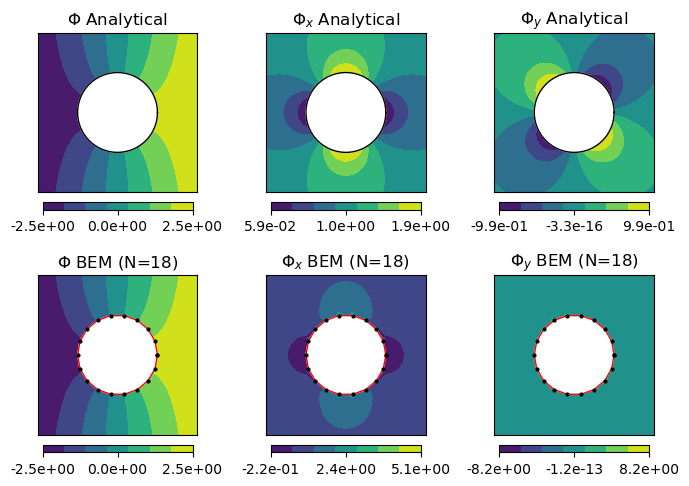

In [6]:
# Plot total potential and its gradient.
nlevels = 8

Pa_levels = np.linspace(Pa_min, Pa_max, nlevels)
Ua_levels = np.linspace(Ua_min, Ua_max, nlevels)
Va_levels = np.linspace(Va_min, Va_max, nlevels)

Pb_levels = np.linspace(Pb_min, Pb_max, nlevels)
Ub_levels = np.linspace(Ub_min, Ub_max, nlevels)
Vb_levels = np.linspace(Vb_min, Vb_max, nlevels)

Pa_ticks = [Pa_min, Pa_med, Pa_max]
Ua_ticks = [Ua_min, Ua_med, Ua_max]
Va_ticks = [Va_min, Va_med, Va_max]

Pb_ticks = [Pb_min, Pb_med, Pb_max]
Ub_ticks = [Ub_min, Ub_med, Ub_max]
Vb_ticks = [Vb_min, Vb_med, Vb_max]

fig, ax = plt.subplots(2, 3, figsize=(7, 5))

ax[0, 0].set_title(r'$\Phi$ Analytical')
ax[0, 1].set_title(r'$\Phi_x$ Analytical')
ax[0, 2].set_title(r'$\Phi_y$ Analytical')

Pa_ax = ax[0, 0].contourf(X, Y, Pa, levels=Pa_levels)
Ua_ax = ax[0, 1].contourf(X, Y, Ua, levels=Ua_levels)
Va_ax = ax[0, 2].contourf(X, Y, Va, levels=Va_levels)

ax[1, 0].set_title(rf'$\Phi$ BEM (N={number_of_elements})')
ax[1, 1].set_title(rf'$\Phi_x$ BEM (N={number_of_elements})')
ax[1, 2].set_title(rf'$\Phi_y$ BEM (N={number_of_elements})')

Pb_ax = ax[1, 0].contourf(X, Y, Pb, levels=Pb_levels)
Ub_ax = ax[1, 1].contourf(X, Y, Ub, levels=Ub_levels)
Vb_ax = ax[1, 2].contourf(X, Y, Vb, levels=Vb_levels)

for i, e in enumerate(ax.ravel()):
    e.set_aspect('equal')
    e.xaxis.set_visible(False)
    e.yaxis.set_visible(False)
    if i < 3:
        e.add_patch(PolygonPatch(vc, color='white'))
        e.plot(xc, yc, 'k-', linewidth=1)
    else:
        e.add_patch(PolygonPatch(C.boundaries[0].vertices, color='white'))
        e.plot(
            C.boundaries[0].vertices[:, 0],
            C.boundaries[0].vertices[:, 1],
            'r-',
            linewidth=1,
            marker='o',
            markersize=2,
            markerfacecolor='k',
            markeredgecolor='k',
        )

fig.colorbar(Pa_ax, ax=ax[0, 0], location='bottom', shrink=0.9, format='%.1e', pad=0.05, ticks=Pa_ticks)
fig.colorbar(Ua_ax, ax=ax[0, 1], location='bottom', shrink=0.9, format='%.1e', pad=0.05, ticks=Ua_ticks)
fig.colorbar(Va_ax, ax=ax[0, 2], location='bottom', shrink=0.9, format='%.1e', pad=0.05, ticks=Va_ticks)
fig.colorbar(Pb_ax, ax=ax[1, 0], location='bottom', shrink=0.9, format='%.1e', pad=0.05, ticks=Pb_ticks)
fig.colorbar(Ub_ax, ax=ax[1, 1], location='bottom', shrink=0.9, format='%.1e', pad=0.05, ticks=Ub_ticks)
fig.colorbar(Vb_ax, ax=ax[1, 2], location='bottom', shrink=0.9, format='%.1e', pad=0.05, ticks=Vb_ticks)

fig.tight_layout()
plt.savefig(f'example02_total_potential_N{number_of_elements}.svg', bbox_inches='tight')
plt.show()

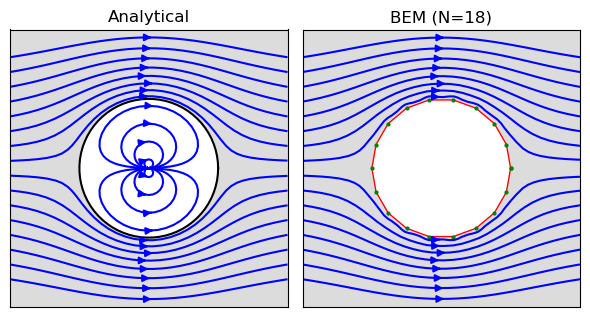

In [7]:
# Plot streamlines
fig, ax = plt.subplots(1, 2, figsize=(6,4))

ax[0].set_title('Analytical')
ax[1].set_title(f'BEM (N={number_of_elements})')

for e in ax:
    e.set_aspect('equal')
    e.set_facecolor('gainsboro')
    e.xaxis.set_visible(False)
    e.yaxis.set_visible(False)

# Analytical streamlines.
external_SPa = np.empty((16, 2))
external_SPa[:, 0] = -2.0
external_SPa[:, 1] = np.linspace(-1.6, 1.6, external_SPa.shape[0])

interior_SPa = np.zeros((8, 2))
interior_SPa[:, 1] = np.linspace(-R + 0.1, R - 0.1, interior_SPa.shape[0])

SPa = np.concatenate((external_SPa, interior_SPa))

bpatch = PolygonPatch(vc, color='white')
ax[0].add_patch(bpatch)
ax[0].plot(xc, yc, 'k')
ax[0].streamplot(X, Y, Ua, Va, start_points=SPa, broken_streamlines=False, color='blue')

# Numerical streamlines.
SPb = np.empty((16, 2))
SPb[:, 0] = -2.0
SPb[:, 1] = np.linspace(-1.6, 1.6, SPb.shape[0])

bpatch = PolygonPatch(C.boundaries[0].vertices, color='white')
ax[1].add_patch(bpatch)
ax[1].plot(
    C.boundaries[0].vertices[:, 0],
    C.boundaries[0].vertices[:, 1],
    'r-',
    linewidth=1,
    marker='o',
    markersize=2,
    markerfacecolor='g',
    markeredgecolor='g',
)

ax[1].streamplot(X, Y, Ub, Vb, start_points=SPb, broken_streamlines=False, color='blue')

fig.tight_layout()
plt.savefig(f'example02_streamlines_N{number_of_elements}.svg', bbox_inches='tight')
plt.show()

In [8]:
# Analytical pressure coefficient.
tv = np.linspace(0.0, 2*np.pi, 100)
Cp_analytical = 1.0 - 4.0 * np.sin(tv)**2

# Numerical pressure coefficient.
xm = C.midpoints[:, 0]
ym = C.midpoints[:, 1]
tm = np.arctan2(ym, xm) + np.pi  # The function arctan2 returns a result between -π and π. I want it to be between 0.0 and 2π.

Rb = Phit_uniform_flow(xm, ym) + bem_solver.r
Cp_bem = 1.0 - Rb**2 / U0**2

# Sorter results from the lowest to the highest angle θ.
tm_sorted_indexes = np.argsort(tm)
tm = tm[tm_sorted_indexes]
Cp_bem = Cp_bem[tm_sorted_indexes]

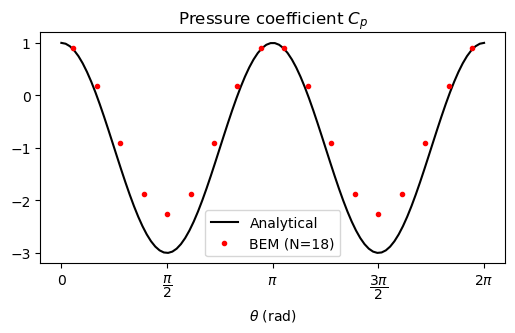

In [9]:
fig, ax = plt.subplots(figsize=(6, 3))

ax.set_title(r'Pressure coefficient $C_p$')

ax.plot(tv, Cp_analytical, '-k', label='Analytical')
ax.plot(tm, Cp_bem, '.r', label=f'BEM (N={number_of_elements})')

ax.set_xlabel(r'$\theta$ (rad)')
ax.set_xticks(np.linspace(0.0, 2*np.pi, 5))
ax.set_xticklabels(['0', r'$\dfrac{\pi}{2}$', r'$\pi$', r'$\dfrac{3\pi}{2}$', r'$2\pi$'])

ax.legend()
plt.savefig(f'example02_pressure_coefficient_N{number_of_elements}.svg', bbox_inches='tight')
plt.show()